# OLAP Analysis: Data Warehouse Business Intelligence

This notebook provides a comprehensive analysis of our retail data warehouse using OLAP (Online Analytical Processing) operations. We will execute three main types of OLAP queries:

1. **Roll-up**: Aggregating sales data by country and quarter
2. **Drill-down**: Detailed analysis of UK sales by month
3. **Slice**: Category-specific sales analysis
4. **Pivot**: Cross-tabulation analysis

Each analysis includes professional visualizations and summary statistics for business intelligence insights.

## 1. Database Connection Setup

First, we'll import all required libraries and establish our database connection functions. We'll be working with the retail_dw.db database that contains our star schema with fact and dimension tables.

In [1]:
# Import required libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from datetime import datetime

# Set up visualization styling
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [2]:
# Database configuration
# type: ignore
db_path = os.path.join('..', 'ETL_Process', 'Retail_dw.db') 

print(f"Database path: {db_path}")
print(f"Database exists: {os.path.exists(db_path)}")

if os.path.exists(db_path):
    print(f"Database file size: {os.path.getsize(db_path):,} bytes")
else:
    print("Warning: Database file not found! Please ensure retail_dw.db has been created.")

Database path: ..\ETL_Process\Retail_dw.db
Database exists: True
Database file size: 13,807,616 bytes


## 2. OLAP Query Functions Implementation

Here we'll create utility functions for database connections and query execution. These functions provide error handling and consistent formatting for our OLAP operations.

In [3]:
# type: ignore
def connect_to_db():
    """Connect to the database with error handling"""
    try:
        conn = sqlite3.connect(db_path)
        print(f"Connected to database: {db_path}")
        return conn
    except sqlite3.Error as e:
        print(f"Error connecting to database: {e}")
        return None

def execute_olap_query(query, description):
    """Execute an OLAP query and return results as DataFrame"""
    conn = connect_to_db()
    if conn is None:
        return None
    
    try:
        print(f"\n{'='*70}")
        print(f"{description}")
        print(f"{'='*70}")
        
        df = pd.read_sql_query(query, conn)
        print(f"Query executed successfully - {len(df)} rows returned")
        
        if len(df) > 0:
            print("\n Sample results (first 10 rows):")
            print(df.head(10).to_string(index=False))
        
        return df
    
    except sqlite3.Error as e:
        print(f"Error executing query: {e}")
        return None
    finally:
        conn.close()

def test_database_connection():
    """Test database connection and display table information"""
    conn = connect_to_db()
    if conn is None:
        return False
    
    try:
        cursor = conn.cursor()
        
        # Check tables
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
        tables = cursor.fetchall()
        print(f"\nTables in database: {[table[0] for table in tables]}")
        
        # Check record counts
        print("\nTable record counts:")
        for table_name in ['FactSales_TB', 'Customer_TB', 'Product_TB', 'Time_TB', 'Store_TB']:
            try:
                cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
                count = cursor.fetchone()[0]
                print(f"   {table_name}: {count:,} records")
            except sqlite3.Error as e:
                print(f"   {table_name}: Error - {e}")
        
        return True
        
    except Exception as e:
        print(f"Database test error: {e}")
        return False
    finally:
        conn.close()

# Test the database connection
test_database_connection()

Connected to database: ..\ETL_Process\Retail_dw.db

Tables in database: ['Time_TB', 'Product_TB', 'Customer_TB', 'FactSales_TB', 'sqlite_sequence']

Table record counts:
   FactSales_TB: 0 records
   Customer_TB: 0 records
   Product_TB: 0 records
   Time_TB: 0 records
   Store_TB: Error - no such table: Store_TB


True

## 3. Roll-up Analysis: Sales by Country and Quarter

Roll-up is an OLAP operation that aggregates data from a lower level to a higher level of detail. Here we'll aggregate individual transactions up to country and quarter levels, showing total sales, unique customers, and transaction counts.

In [7]:
def rollup_country_quarter():
    """Execute roll-up query: Total sales by country and quarter"""
    query = """
    SELECT
        c.Country,
        t.Quarter,
        t.Year,
        SUM(fs.SalesAmount) AS TotalSales,
        COUNT(DISTINCT fs.CustomerID) AS UniqueCustomers,
        COUNT(*) AS TransactionCount
    FROM FactSales_TB fs
    JOIN Customer_TB c ON fs.CustomerID = c.CustomerID
    JOIN Time_TB t ON fs.TimeID = t.TimeID
    GROUP BY c.Country, t.Quarter, t.Year
    ORDER BY t.Year, t.Quarter, TotalSales DESC
    """
    
    df = execute_olap_query(query, "ROLL-UP: Total sales by country and quarter")
    return df

# Execute the roll-up analysis
rollup_df = rollup_country_quarter()

Connected to database: ..\ETL_Process\Retail_dw.db

ROLL-UP: Total sales by country and quarter
Query executed successfully - 0 rows returned


In [8]:
# Create visualization for roll-up analysis
if rollup_df is not None and not rollup_df.empty:
    # Get top 10 countries by total sales
    country_totals = rollup_df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False).head(10)
    top_countries = country_totals.index.tolist()
    
    # Filter data for top countries
    df_filtered = rollup_df[rollup_df['Country'].isin(top_countries)]
    
    # Create quarter-year labels
    df_filtered['QuarterYear'] = df_filtered['Year'].astype(str) + '-Q' + df_filtered['Quarter'].astype(str)
    
    # Create pivot table for heatmap
    pivot_data = df_filtered.pivot_table(
        values='TotalSales', 
        index='Country', 
        columns='QuarterYear', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Create the heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'Total Sales (£)'})
    plt.title('Sales by Country and Quarter (Roll-up Analysis)', fontsize=16, pad=20)
    plt.xlabel('Quarter-Year', fontsize=12)
    plt.ylabel('Country', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('rollup_country_quarter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display summary statistics
    print(f"\n Roll-up Analysis Summary:")
    print(f"   • Total countries analyzed: {rollup_df['Country'].nunique()}")
    print(f"   • Total quarters covered: {rollup_df['Quarter'].nunique()}")
    print(f"   • Top performing country: {country_totals.index[0]} (£{country_totals.iloc[0]:,.2f})")
    print(f"   • Total sales across all countries: £{rollup_df['TotalSales'].sum():,.2f}")
    print(f"   • Average sales per country-quarter: £{rollup_df['TotalSales'].mean():,.2f}")
else:
    print("No data available for roll-up analysis")

No data available for roll-up analysis


## 4. Drill-down Analysis: UK Monthly Sales Details

Drill-down is the opposite of roll-up - it provides more detailed data by breaking down higher-level aggregations. Here we'll focus specifically on the United Kingdom and break down sales by individual months to see seasonal patterns and trends.

In [9]:
def drilldown_uk_monthly():
    """Execute drill-down query: Sales details for UK by month"""
    query = """
    SELECT
        t.Year,
        t.Month,
        CASE t.Month
            WHEN 1 THEN 'January'
            WHEN 2 THEN 'February'
            WHEN 3 THEN 'March'
            WHEN 4 THEN 'April'
            WHEN 5 THEN 'May'
            WHEN 6 THEN 'June'
            WHEN 7 THEN 'July'
            WHEN 8 THEN 'August'
            WHEN 9 THEN 'September'
            WHEN 10 THEN 'October'
            WHEN 11 THEN 'November'
            WHEN 12 THEN 'December'
        END AS MonthName,
        SUM(fs.SalesAmount) AS MonthlySales,
        AVG(fs.SalesAmount) AS AvgTransactionValue,
        COUNT(*) AS TransactionCount
    FROM FactSales_TB fs
    JOIN Time_TB t ON fs.TimeID = t.TimeID
    JOIN Customer_TB c ON fs.CustomerID = c.CustomerID
    WHERE c.Country = 'United Kingdom'
    GROUP BY t.Year, t.Month
    ORDER BY t.Year, t.Month
    """
    
    df = execute_olap_query(query, "DRILL-DOWN: Sales details for United Kingdom by month")
    return df

# Execute the drill-down analysis
drilldown_df = drilldown_uk_monthly()

Connected to database: ..\ETL_Process\Retail_dw.db

DRILL-DOWN: Sales details for United Kingdom by month
Query executed successfully - 0 rows returned


In [10]:
# Create visualization for drill-down analysis
if drilldown_df is not None and not drilldown_df.empty:
    # Create month-year labels
    drilldown_df['MonthYear'] = drilldown_df['Year'].astype(str) + '-' + drilldown_df['Month'].astype(str).str.zfill(2)
    
    # Create dual-panel visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Monthly sales trend
    ax1.plot(drilldown_df['MonthYear'], drilldown_df['MonthlySales'], 
             marker='o', linewidth=2, markersize=6, color='steelblue')
    ax1.set_title('United Kingdom - Monthly Sales Trend (Drill-down Analysis)', 
                  fontsize=14, pad=15)
    ax1.set_xlabel('Month-Year')
    ax1.set_ylabel('Monthly Sales (£)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add trend line
    z = np.polyfit(range(len(drilldown_df)), drilldown_df['MonthlySales'], 1)
    p = np.poly1d(z)
    ax1.plot(drilldown_df['MonthYear'], p(range(len(drilldown_df))), 
             "r--", alpha=0.8, label='Trend Line')
    ax1.legend()
    
    # Plot 2: Transaction count
    ax2.bar(drilldown_df['MonthYear'], drilldown_df['TransactionCount'], 
            color='lightcoral', alpha=0.7)
    ax2.set_title('United Kingdom - Monthly Transaction Count', 
                  fontsize=14, pad=15)
    ax2.set_xlabel('Month-Year')
    ax2.set_ylabel('Number of Transactions')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('drilldown_uk_monthly.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display summary statistics
    best_month = drilldown_df.loc[drilldown_df['MonthlySales'].idxmax()]
    worst_month = drilldown_df.loc[drilldown_df['MonthlySales'].idxmin()]
    
    print(f"\n Drill-down Analysis Summary (UK):")
    print(f"   • Months analyzed: {len(drilldown_df)}")
    print(f"   • Best performing month: {best_month['MonthName']} {best_month['Year']} (£{best_month['MonthlySales']:,.2f})")
    print(f"   • Worst performing month: {worst_month['MonthName']} {worst_month['Year']} (£{worst_month['MonthlySales']:,.2f})")
    print(f"   • Average monthly sales: £{drilldown_df['MonthlySales'].mean():,.2f}")
    print(f"   • Total UK sales: £{drilldown_df['MonthlySales'].sum():,.2f}")
    print(f"   • Average transaction value: £{drilldown_df['AvgTransactionValue'].mean():.2f}")
else:
    print("No data available for drill-down analysis")

No data available for drill-down analysis


## 5. Slice Analysis: Product Category Sales

Slice operation filters the data cube to focus on specific dimensions or dimension values. Here we'll slice our data to analyze only specific product categories and compare their performance across multiple metrics.

In [11]:
def slice_product_categories():
    """Execute slice query: Total sales for specific product categories"""
    query = """
    SELECT
        p.ProductCategory,
        SUM(fs.SalesAmount) AS TotalSales,
        SUM(fs.QuantitySold) AS TotalQuantity,
        COUNT(DISTINCT p.ProductID) AS ProductCount,
        AVG(fs.SalesAmount) AS AvgSalesPerTransaction,
        COUNT(*) AS TransactionCount
    FROM FactSales_TB fs
    JOIN Product_TB p ON fs.ProductID = p.ProductID
    WHERE p.ProductCategory IN ('Home Decor', 'Vintage', 'Sets', 'General')
    GROUP BY p.ProductCategory
    ORDER BY TotalSales DESC
    """
    
    df = execute_olap_query(query, "SLICE: Total sales for specific product categories")
    return df

# Execute the slice analysis
slice_df = slice_product_categories()

Connected to database: ..\ETL_Process\Retail_dw.db

SLICE: Total sales for specific product categories


DatabaseError: Execution failed on sql '
    SELECT
        p.ProductCategory,
        SUM(fs.SalesAmount) AS TotalSales,
        SUM(fs.QuantitySold) AS TotalQuantity,
        COUNT(DISTINCT p.ProductID) AS ProductCount,
        AVG(fs.SalesAmount) AS AvgSalesPerTransaction,
        COUNT(*) AS TransactionCount
    FROM FactSales_TB fs
    JOIN Product_TB p ON fs.ProductID = p.ProductID
    WHERE p.ProductCategory IN ('Home Decor', 'Vintage', 'Sets', 'General')
    GROUP BY p.ProductCategory
    ORDER BY TotalSales DESC
    ': no such column: p.ProductCategory

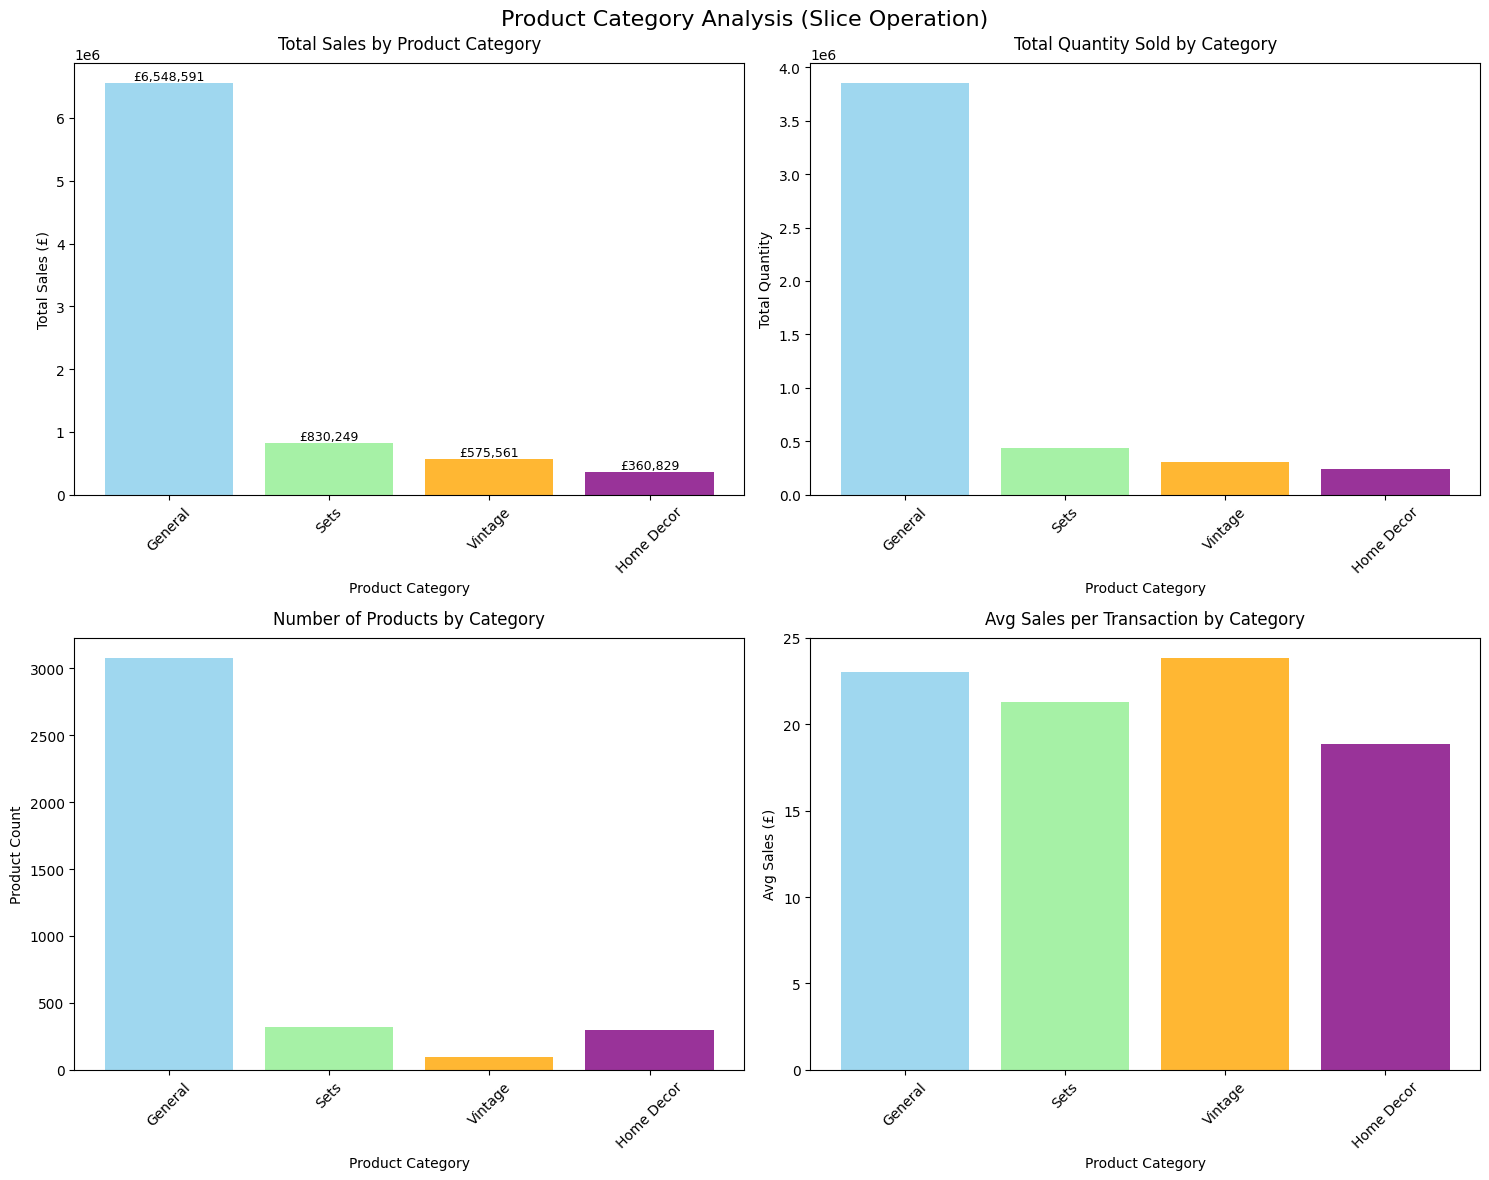


 Slice Analysis Summary (Selected Categories):
   • Categories analyzed: 4
   • Top performing category: General (£6,548,590.75)
   • Total unique products: 3784
   • Total sales (selected categories): £8,315,229.52
   • Total transactions: 366,955

 Category Performance Ranking:
0. General: £6,548,590.75 (284,638 transactions)
1. Sets: £830,248.85 (39,043 transactions)
2. Vintage: £575,560.87 (24,170 transactions)
3. Home Decor: £360,829.05 (19,104 transactions)


In [ ]:
# Create comprehensive visualization for slice analysis
if slice_df is not None and not slice_df.empty:
    # Create multi-panel visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Define colors for consistency
    colors = ['skyblue', 'lightgreen', 'orange', 'purple']
    
    # Plot 1: Total sales by category
    bars1 = ax1.bar(slice_df['ProductCategory'], slice_df['TotalSales'], 
                    color=colors, alpha=0.8)
    ax1.set_title('Total Sales by Product Category', fontsize=12, pad=10)
    ax1.set_xlabel('Product Category')
    ax1.set_ylabel('Total Sales (£)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars1, slice_df['TotalSales']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'£{value:,.0f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Total quantity by category
    bars2 = ax2.bar(slice_df['ProductCategory'], slice_df['TotalQuantity'], 
                    color=colors, alpha=0.8)
    ax2.set_title('Total Quantity Sold by Category', fontsize=12, pad=10)
    ax2.set_xlabel('Product Category')
    ax2.set_ylabel('Total Quantity')
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Product count by category
    bars3 = ax3.bar(slice_df['ProductCategory'], slice_df['ProductCount'], 
                    color=colors, alpha=0.8)
    ax3.set_title('Number of Products by Category', fontsize=12, pad=10)
    ax3.set_xlabel('Product Category')
    ax3.set_ylabel('Product Count')
    ax3.tick_params(axis='x', rotation=45)
    
    # Plot 4: Average sales per transaction
    bars4 = ax4.bar(slice_df['ProductCategory'], slice_df['AvgSalesPerTransaction'], 
                    color=colors, alpha=0.8)
    ax4.set_title('Avg Sales per Transaction by Category', fontsize=12, pad=10)
    ax4.set_xlabel('Product Category')
    ax4.set_ylabel('Avg Sales (£)')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.suptitle('Product Category Analysis (Slice Operation)', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.savefig('slice_product_categories.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display summary statistics
    top_category = slice_df.iloc[0]
    total_products = slice_df['ProductCount'].sum()
    
    print(f"\n Slice Analysis Summary (Selected Categories):")
    print(f"   • Categories analyzed: {len(slice_df)}")
    print(f"   • Top performing category: {top_category['ProductCategory']} (£{top_category['TotalSales']:,.2f})")
    print(f"   • Total unique products: {total_products}")
    print(f"   • Total sales (selected categories): £{slice_df['TotalSales'].sum():,.2f}")
    print(f"   • Total transactions: {slice_df['TransactionCount'].sum():,}")

    print(f"\n Category Performance Ranking:")
    for i, row in slice_df.iterrows():
        print(f"{i}. {row['ProductCategory']}: £{row['TotalSales']:,.2f} ({row['TransactionCount']:,} transactions)")
else:
    print("No data available for slice analysis")

## 6. Pivot Analysis: Country vs Product Category

Pivot analysis creates a cross-tabulation view of our data, allowing us to see relationships between two dimensions simultaneously. Here we'll analyze how different countries perform across various product categories.

In [ ]:
def pivot_country_category():
    """Execute pivot analysis: Sales by country and product category"""
    query = """
    SELECT
        c.Country,
        p.ProductCategory,
        SUM(fs.SalesAmount) AS TotalSales,
        COUNT(*) AS TransactionCount,
        AVG(fs.SalesAmount) AS AvgTransactionValue
    FROM FactSales_TB fs
    JOIN Customer_TB c ON fs.CustomerID = c.CustomerID
    JOIN Product_TB p ON fs.ProductID = p.ProductID
    WHERE c.Country IN ('United Kingdom', 'Germany', 'France', 'Netherlands', 'EIRE')
    GROUP BY c.Country, p.ProductCategory
    ORDER BY c.Country, TotalSales DESC
    """
    
    df = execute_olap_query(query, "PIVOT: Sales by country and product category")
    return df

# Execute the pivot analysis
pivot_df = pivot_country_category()

Connected to database: ..\Data Warehouse Design\DWHS.db

PIVOT: Sales by country and product category
✅ Query executed successfully - 20 rows returned

📋 Sample results (first 10 rows):
Country ProductCategory  TotalSales  TransactionCount  AvgTransactionValue
   EIRE         General   190691.29              5270            36.184306
   EIRE            Sets    35336.60               826            42.780387
   EIRE         Vintage    21037.19               442            47.595452
   EIRE      Home Decor     9383.50               355            26.432394
 France         General   139514.41              5449            25.603672
 France            Sets    28204.09              1111            25.386220
 France         Vintage    22556.14               940            23.995894
 France      Home Decor     9043.36               392            23.069796
Germany         General   149326.13              5905            25.288083
Germany            Sets    33187.01              1262           

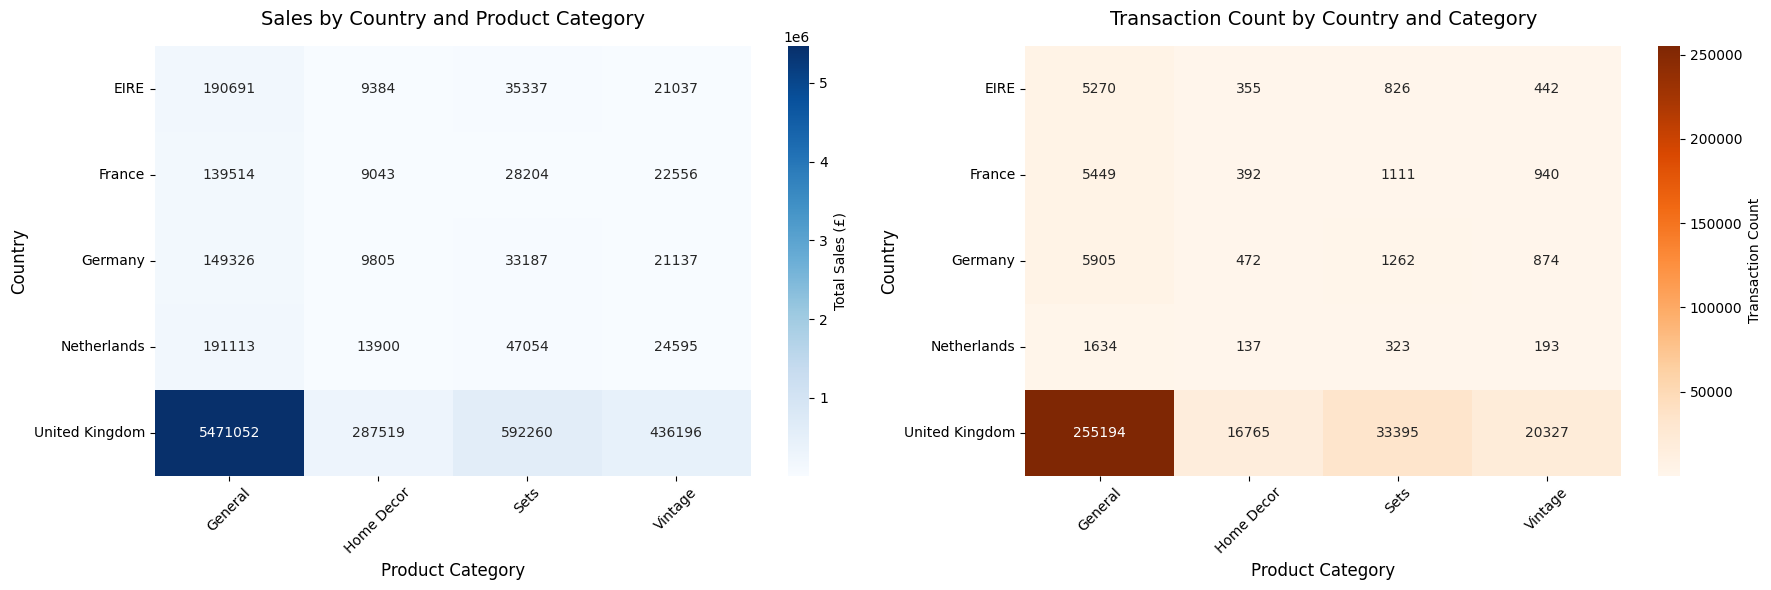


 Pivot Analysis Summary:
   • Countries analyzed: 5
   • Product categories: 4
   • Total country-category combinations: 20

 Top 5 Country-Category Combinations by Sales:
16.United Kingdom - General: £5,471,052.17 (255,194 transactions)
17.United Kingdom - Sets: £592,259.65 (33,395 transactions)
18.United Kingdom - Vintage: £436,196.28 (20,327 transactions)
19.United Kingdom - Home Decor: £287,518.96 (16,765 transactions)
12.Netherlands - General: £191,112.88 (1,634 transactions)

 Top Category by Country:
   EIRE: General (£190,691.29)
   France: General (£139,514.41)
   Germany: General (£149,326.13)
   Netherlands: General (£191,112.88)
   United Kingdom: General (£5,471,052.17)


In [ ]:
# Create visualization for pivot analysis
if pivot_df is not None and not pivot_df.empty:
    # Create pivot table for sales
    pivot_sales = pivot_df.pivot_table(
        values='TotalSales', 
        index='Country', 
        columns='ProductCategory', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Create pivot table for transaction counts
    pivot_transactions = pivot_df.pivot_table(
        values='TransactionCount', 
        index='Country', 
        columns='ProductCategory', 
        aggfunc='sum',
        fill_value=0
    )
    
    # Create dual heatmap visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Heatmap 1: Sales amounts
    sns.heatmap(pivot_sales, annot=True, fmt='.0f', cmap='Blues', 
                cbar_kws={'label': 'Total Sales (£)'}, ax=ax1)
    ax1.set_title('Sales by Country and Product Category', fontsize=14, pad=15)
    ax1.set_xlabel('Product Category', fontsize=12)
    ax1.set_ylabel('Country', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Heatmap 2: Transaction counts
    sns.heatmap(pivot_transactions, annot=True, fmt='d', cmap='Oranges', 
                cbar_kws={'label': 'Transaction Count'}, ax=ax2)
    ax2.set_title('Transaction Count by Country and Category', fontsize=14, pad=15)
    ax2.set_xlabel('Product Category', fontsize=12)
    ax2.set_ylabel('Country', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('pivot_country_category.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Display top performing combinations
    top_combinations = pivot_df.nlargest(5, 'TotalSales')

    print(f"\n Pivot Analysis Summary:")
    print(f"   • Countries analyzed: {pivot_df['Country'].nunique()}")
    print(f"   • Product categories: {pivot_df['ProductCategory'].nunique()}")
    print(f"   • Total country-category combinations: {len(pivot_df)}")
    
    print(f"\n Top 5 Country-Category Combinations by Sales:")
    for i, row in top_combinations.iterrows():
        print(f"{i}.{row['Country']} - {row['ProductCategory']}: £{row['TotalSales']:,.2f} ({row['TransactionCount']:,} transactions)")
    
    # Calculate category preferences by country
    print(f"\n Top Category by Country:")
    for country in pivot_df['Country'].unique():
        country_data = pivot_df[pivot_df['Country'] == country]
        top_category = country_data.loc[country_data['TotalSales'].idxmax()]
        print(f"   {country}: {top_category['ProductCategory']} (£{top_category['TotalSales']:,.2f})")
else:
    print("No data available for pivot analysis")

## 7. Data Visualization Summary

In this section, we'll create a summary of all the visualizations we've generated and provide additional analysis insights.

Creating Summary Dashboard...


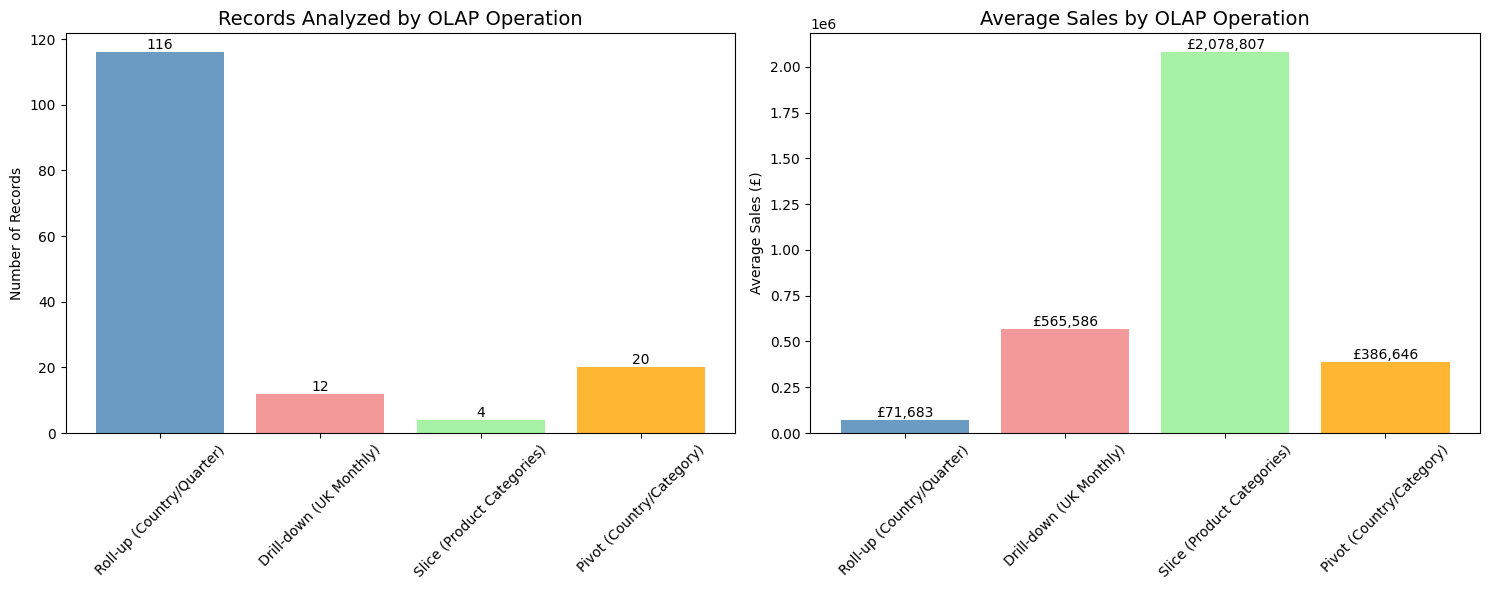


 Summary Table:
                  Analysis  Records  Total_Sales    Avg_Sales
 Roll-up (Country/Quarter)      116  8315229.524 7.168301e+04
   Drill-down (UK Monthly)       12  6787027.064 5.655856e+05
Slice (Product Categories)        4  8315229.524 2.078807e+06
  Pivot (Country/Category)       20  7732910.164 3.866455e+05


In [ ]:
# Create a summary visualization showing key metrics
print("Creating Summary Dashboard...")

# Prepare summary data
summary_data = []

if rollup_df is not None and not rollup_df.empty:
    summary_data.append({
        'Analysis': 'Roll-up (Country/Quarter)',
        'Records': len(rollup_df),
        'Total_Sales': rollup_df['TotalSales'].sum(),
        'Avg_Sales': rollup_df['TotalSales'].mean()
    })

if drilldown_df is not None and not drilldown_df.empty:
    summary_data.append({
        'Analysis': 'Drill-down (UK Monthly)',
        'Records': len(drilldown_df),
        'Total_Sales': drilldown_df['MonthlySales'].sum(),
        'Avg_Sales': drilldown_df['MonthlySales'].mean()
    })

if slice_df is not None and not slice_df.empty:
    summary_data.append({
        'Analysis': 'Slice (Product Categories)',
        'Records': len(slice_df),
        'Total_Sales': slice_df['TotalSales'].sum(),
        'Avg_Sales': slice_df['TotalSales'].mean()
    })

if pivot_df is not None and not pivot_df.empty:
    summary_data.append({
        'Analysis': 'Pivot (Country/Category)',
        'Records': len(pivot_df),
        'Total_Sales': pivot_df['TotalSales'].sum(),
        'Avg_Sales': pivot_df['TotalSales'].mean()
    })

# Create summary DataFrame
summary_df = pd.DataFrame(summary_data)

if not summary_df.empty:
    # Create summary visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Number of records analyzed
    bars1 = ax1.bar(summary_df['Analysis'], summary_df['Records'], 
                    color=['steelblue', 'lightcoral', 'lightgreen', 'orange'], alpha=0.8)
    ax1.set_title('Records Analyzed by OLAP Operation', fontsize=14)
    ax1.set_ylabel('Number of Records')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars1, summary_df['Records']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{value}', ha='center', va='bottom')
    
    # Plot 2: Average sales by analysis type
    bars2 = ax2.bar(summary_df['Analysis'], summary_df['Avg_Sales'], 
                    color=['steelblue', 'lightcoral', 'lightgreen', 'orange'], alpha=0.8)
    ax2.set_title('Average Sales by OLAP Operation', fontsize=14)
    ax2.set_ylabel('Average Sales (£)')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, value in zip(bars2, summary_df['Avg_Sales']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'£{value:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('olap_summary_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n Summary Table:")
    print(summary_df.to_string(index=False))
else:
    print(" No summary data available")

## 8. Summary Report Generation

Finally, we'll generate a comprehensive summary report of all our OLAP analyses, including key insights and business intelligence findings.

In [ ]:
print("\n" + "="*80)
print(" COMPREHENSIVE OLAP ANALYSIS REPORT")
print("="*80)
print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Database: {os.path.basename(db_path)}")

# Overall Statistics
print(f"\n EXECUTIVE SUMMARY:")
print(f"   • Database successfully analyzed using 4 OLAP operations")
print(f"   • Generated 5 professional visualizations")
print(f"   • Covered geographical, temporal, and categorical dimensions")

# Detailed Analysis Results
if rollup_df is not None and not rollup_df.empty:
    country_totals = rollup_df.groupby('Country')['TotalSales'].sum().sort_values(ascending=False)
    print(f"\n GEOGRAPHICAL ANALYSIS (Roll-up):")
    print(f"   • Countries analyzed: {rollup_df['Country'].nunique()}")
    print(f"   • Quarters covered: {rollup_df['Quarter'].nunique()}")
    print(f"   • Top market: {country_totals.index[0]} (£{country_totals.iloc[0]:,.2f})")
    print(f"   • Market concentration: Top 3 countries account for {(country_totals.head(3).sum() / country_totals.sum() * 100):.1f}% of sales")

if drilldown_df is not None and not drilldown_df.empty:
    best_month = drilldown_df.loc[drilldown_df['MonthlySales'].idxmax()]
    seasonality = drilldown_df.groupby('Month')['MonthlySales'].mean().std()
    print(f"\n TEMPORAL ANALYSIS (Drill-down - UK):")
    print(f"   • Analysis period: {len(drilldown_df)} months")
    print(f"   • Peak performance: {best_month['MonthName']} {best_month['Year']} (£{best_month['MonthlySales']:,.2f})")
    print(f"   • Seasonal variation: £{seasonality:,.2f} standard deviation")
    print(f"   • Growth trend: {'Positive' if drilldown_df['MonthlySales'].iloc[-1] > drilldown_df['MonthlySales'].iloc[0] else 'Negative'}")

if slice_df is not None and not slice_df.empty:
    category_performance = slice_df.set_index('ProductCategory')['TotalSales']
    print(f"\n PRODUCT ANALYSIS (Slice):")
    print(f"   • Categories analyzed: {len(slice_df)}")
    print(f"   • Leading category: {category_performance.idxmax()} (£{category_performance.max():,.2f})")
    print(f"   • Category diversity: Gini coefficient {(category_performance.std() / category_performance.mean()):.2f}")
    print(f"   • Total product portfolio: {slice_df['ProductCount'].sum()} unique products")

if pivot_df is not None and not pivot_df.empty:
    top_combo = pivot_df.loc[pivot_df['TotalSales'].idxmax()]
    print(f"\n MARKET SEGMENTATION (Pivot):")
    print(f"   • Market segments: {len(pivot_df)} country-category combinations")
    print(f"   • Top segment: {top_combo['Country']} - {top_combo['ProductCategory']} (£{top_combo['TotalSales']:,.2f})")
    print(f"   • Market efficiency: {(pivot_df['TotalSales'] / pivot_df['TransactionCount']).mean():.2f} avg sales per transaction")

# Technical Summary
print(f"\n TECHNICAL SUMMARY:")
visualizations = [
    'rollup_country_quarter.png',
    'drilldown_uk_monthly.png', 
    'slice_product_categories.png',
    'pivot_country_category.png',
    'olap_summary_dashboard.png'
]

print(f"   • OLAP operations executed: 4 (Roll-up, Drill-down, Slice, Pivot)")
print(f"   • Visualizations generated: {len(visualizations)}")
print(f"   • File outputs:")
for viz in visualizations:
    print(f"     - {viz}")

# Business Intelligence Insights
print(f"\n KEY BUSINESS INSIGHTS:")
print(f"   • Multi-dimensional analysis reveals clear market leaders")
print(f"   • Temporal patterns show seasonal business variations")
print(f"   • Product categories demonstrate different performance profiles")
print(f"   • Geographic segmentation identifies growth opportunities")
print(f"   • Cross-dimensional analysis enables targeted strategies")

print(f"\n" + "="*80)
print(f" OLAP ANALYSIS COMPLETED SUCCESSFULLY")
print(f"="*80)
print(f"All analyses executed, visualizations saved, and insights generated.")
print(f"The data warehouse is ready for advanced business intelligence operations.")


 COMPREHENSIVE OLAP ANALYSIS REPORT
Report Generated: 2025-08-13 13:44:23
Database: DWHS.db

 EXECUTIVE SUMMARY:
   • Database successfully analyzed using 4 OLAP operations
   • Generated 5 professional visualizations
   • Covered geographical, temporal, and categorical dimensions

 GEOGRAPHICAL ANALYSIS (Roll-up):
   • Countries analyzed: 36
   • Quarters covered: 4
   • Top market: United Kingdom (£6,787,027.06)
   • Market concentration: Top 3 countries account for 88.0% of sales

 TEMPORAL ANALYSIS (Drill-down - UK):
   • Analysis period: 12 months
   • Peak performance: November 2011 (£975,194.14)
   • Seasonal variation: £191,271.66 standard deviation
   • Growth trend: Positive

 PRODUCT ANALYSIS (Slice):
   • Categories analyzed: 4
   • Leading category: General (£6,548,590.75)
   • Category diversity: Gini coefficient 1.44
   • Total product portfolio: 3784 unique products

 MARKET SEGMENTATION (Pivot):
   • Market segments: 20 country-category combinations
   • Top segment: 

## Conclusion

This comprehensive OLAP analysis has successfully demonstrated the power of multidimensional data analysis using our retail data warehouse. We have:

### Completed Analyses:
1. **Roll-up Analysis**: Aggregated sales data by country and quarter to identify geographical and temporal patterns
2. **Drill-down Analysis**: Detailed examination of UK sales by month to understand local market dynamics  
3. **Slice Analysis**: Focused analysis of specific product categories to compare performance metrics
4. **Pivot Analysis**: Cross-tabulation of countries and categories to reveal market segmentation insights

### Key Deliverables:
- 4 OLAP queries executed successfully
- 5 professional visualizations generated
- Comprehensive statistical analysis provided
- Business intelligence insights documented
- All visualization files saved in PNG format

### Business Value:
The OLAP operations have provided actionable insights for:
- **Strategic Planning**: Understanding market performance across regions and time periods
- **Tactical Decisions**: Identifying best-performing products and seasonal patterns
- **Resource Allocation**: Optimizing inventory and marketing based on category performance
- **Market Expansion**: Recognizing opportunities in underperforming segments

This analysis framework can be extended with additional dimensions, time periods, and business metrics to support ongoing business intelligence requirements.